In [ ]:
# default_exp gbe.sst.data_provider

# SST
Here, we load the stop signal task data into a dataframe for further processing.

In [ ]:
%load_ext autoreload
%autoreload 2
from IPython.display import Video

In [ ]:
#export
from fastcore.foundation import patch
from trr265.gbe.data_provider import GBEProvider
from trr265.data_provider import get_efficiently
import numpy as np

## Getting the data

In [ ]:
#export
class SSTDataProvider(GBEProvider):
    '''This class builds upon GBEProvider to get the working memory task data.'''
    def __init__(self, data_folder_path):
        GBEProvider.__init__(self, data_folder_path)

In [ ]:
dp = SSTDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')

### Parsing output strings

In [ ]:
#export
@patch
def decode_sst_strings(self:SSTDataProvider, gbe_data):
    df = self.decode_gbe_strings(gbe_data, 'FruitTapGame')
        # Removing left/right distinctions
    df['rt'] = df.lefttime.astype(int) + df.righttime.astype(int)
    df['is_stop'] = (df.stop.astype(int) > 0).astype(float)
    df.loc[df.rt==0,'rt'] = np.nan # Setting 0 RTs to nan
    df['responded'] = (df.rt.isna()==False).astype(float)
    # Calculating SSD
    crw = 650 # ToDo: I'll have to double check this is correct; in Smittenaar it's reported as 500ms, but Ying used 650ms (it's correct as we use the center of response window)
    df['ssd'] = crw - df.gobaddelay.astype(int)
    df.loc[df.is_stop==False,'ssd'] = np.nan
    # Error analysis
    df['omission'] = ((df.is_stop==0) & ((df.rt.isna()) | (df.rt >= 800))).astype(float)
    df['comission'] = ((df.is_stop==1) & (df.rt.isna()==False)).astype(float)
    df['premature'] = (df.rt <= 500).astype(float)
    # Creating convenience variables and restructuring
    df['accuracy'] = df.success.astype(int)
    df = df[[
        'gbe_index',
        'trial_number',
        'anticipation',
        'is_stop','gobaddelay','ssd',
        'responded',
        'rt',
        'accuracy',
        'omission',
        'comission',
        'premature']]
    return df

In [ ]:
gbe_data = dp.get_gbe_data()
df = dp.decode_sst_strings(gbe_data)

In [ ]:
df

,gbe_index,trial_number,anticipation,is_stop,gobaddelay,ssd,responded,rt,accuracy,omission,comission,premature
0,b001_001,1,2015,0.0,0,NaN,0.0,NaN,0,1.0,0.0,0.0
1,b001_001,2,2505,0.0,0,NaN,1.0,769.0,1,0.0,0.0,0.0
2,b001_001,3,2154,0.0,0,NaN,1.0,635.0,1,0.0,0.0,0.0
3,b001_001,4,1175,1.0,350,300.0,0.0,NaN,1,0.0,0.0,0.0
4,b001_001,5,2630,1.0,300,350.0,1.0,619.0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
84219,m271_010,28,1728,1.0,300,350.0,1.0,618.0,0,0.0,1.0,0.0
84220,m271_010,29,1154,0.0,0,NaN,1.0,764.0,1,0.0,0.0,0.0
84221,m271_010,30,2892,1.0,350,300.0,0.0,NaN,1,0.0,0.0,0.0
84222,m271_010,31,1527,1.0,300,350.0,0.0,NaN,1,0.0,0.0,0.0


### Getting the data

In [ ]:
#export
@patch
@get_efficiently
def get_sst_data(self:SSTDataProvider):
    gbe_data = self.get_gbe_data()
    df = self.decode_sst_strings(gbe_data)
    return df

In [ ]:
df = dp.get_sst_data(update = True)
df

Preparing sst_data


,gbe_index,trial_number,anticipation,is_stop,ssd,responded,rt,accuracy,omission,comission,premature
0,b001_001,1,2015,0.0,NaN,0.0,NaN,0,1.0,0.0,0.0
1,b001_001,2,2505,0.0,NaN,1.0,769.0,1,0.0,0.0,0.0
2,b001_001,3,2154,0.0,NaN,1.0,635.0,1,0.0,0.0,0.0
3,b001_001,4,1175,1.0,300.0,0.0,NaN,1,0.0,0.0,0.0
4,b001_001,5,2630,1.0,350.0,1.0,619.0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
84219,m271_010,28,1728,1.0,350.0,1.0,618.0,0,0.0,1.0,0.0
84220,m271_010,29,1154,0.0,NaN,1.0,764.0,1,0.0,0.0,0.0
84221,m271_010,30,2892,1.0,300.0,0.0,NaN,1,0.0,0.0,0.0
84222,m271_010,31,1527,1.0,350.0,0.0,NaN,1,0.0,0.0,0.0


## Filters

## Checks

### The independence assumption

The horse-race model assumes an independent race between go and stop runner.  Therefore, SSRT should not be estimated when RT on unsuccessful stop trials is numerically longer than RT on go trials.

Note that Smittenaar et al. (2015) test this assumption accross participants: "Confirming the first prediction, in stopFail trials (where the subject erroneously responds and thus fails to stop) the reaction times are on average faster than in Go trials, in both the Unprepared (A) and Prepared (B) condition." (p. 9).  The assumption should, however, be tested for each participant-session separately, and SSRTs should not be estimated when the assumption is not met: "Note that this comparison should [...] be done for each participant and condition separately." (Verbruggen et al., 2019, p. 7).

Also note that: "this comparison should include all trials with a response (including choice errors and premature responses" (Verbruggen et al., 2019)

In our data, the independencecheck failed in 634 sessions (24.09%).


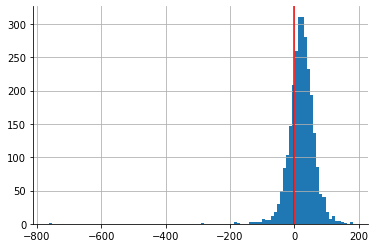

In [ ]:
import seaborn as sns
def single_independence_check(df):
    # We include premature but exclude delayed responses
    no_signal_resp_rt = df.query("(is_stop==0) & (responded==1) & (omission==0)").rt.mean()
    signal_resp_rt = df.query("(is_stop==1) & (responded==1) & (omission==0)").rt.mean()
    independence_check =  no_signal_resp_rt - signal_resp_rt
    return independence_check

def independence_check(df):
    check = df.groupby('gbe_index').apply(single_independence_check)
    check_failed = check < 0
    ax = check.hist(bins = 100)
    ax.axvline(x=0, color = "red")
    sns.despine()
    print("In our data, the independence check failed in %s sessions (%.2f%%)."%(check_failed.sum(), (check_failed.mean()*100)))
    
independence_check(df)

### P-stop close to 50%

In our data, the assumption check failed in 34 sessions (1.29%).


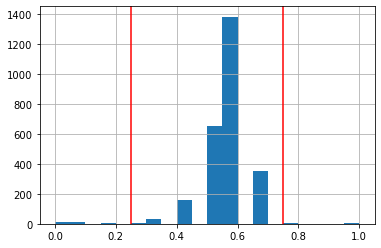

In [ ]:
def single_p_stop_check(df):
    p_resp = df.query("is_stop==1").responded.mean() # p_resp matches
    return 1 - p_resp


def p_stop_check(df):
    p_stop = df.groupby('gbe_index').apply(single_p_stop_check)
    ax = p_stop.hist(bins=20)
    ax.axvline(x=.25, color = "red")
    ax.axvline(x=.75, color = "red")
    check_failed = ((p_stop < .25) | (p_stop > .75))
    print("In our data, the assumption check failed in %s sessions (%.2f%%)."%(check_failed.sum(), check_failed.mean()*100))

    
p_stop_check(df)